# Check GPU/CPU availability

In [13]:
# Ran on Tensorflow 1.6.0, python 3.5, keras 2.1.3 
# Pipline Demo. oushesh

In [14]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11642740469730767097
]


In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from scipy.misc import imresize

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

import wget

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from scipy.misc import imresize

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

# Loading Dataset 
Loading Images

In [9]:
#Wget to load Dataset
import wget
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2018-05-17 11:40:57--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2018-05-17 11:40:57--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4,7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz       0%[                    ]   8,29M  2,16MB/s    eta 36m 47s^C


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('food-101.tar.gz', 'r')
zip_ref.extractall('food-101/')

In [17]:
!ls food-101/images

apple_pie  baby_back_ribs  baklava


In [18]:
!ls food-101/images/apple_pie/ | head -10

1005649.jpg
1011328.jpg
101251.jpg
1014775.jpg
1026328.jpg
1028787.jpg
1034399.jpg
103801.jpg
1038694.jpg
1043283.jpg
ls: write error: Broken pipe


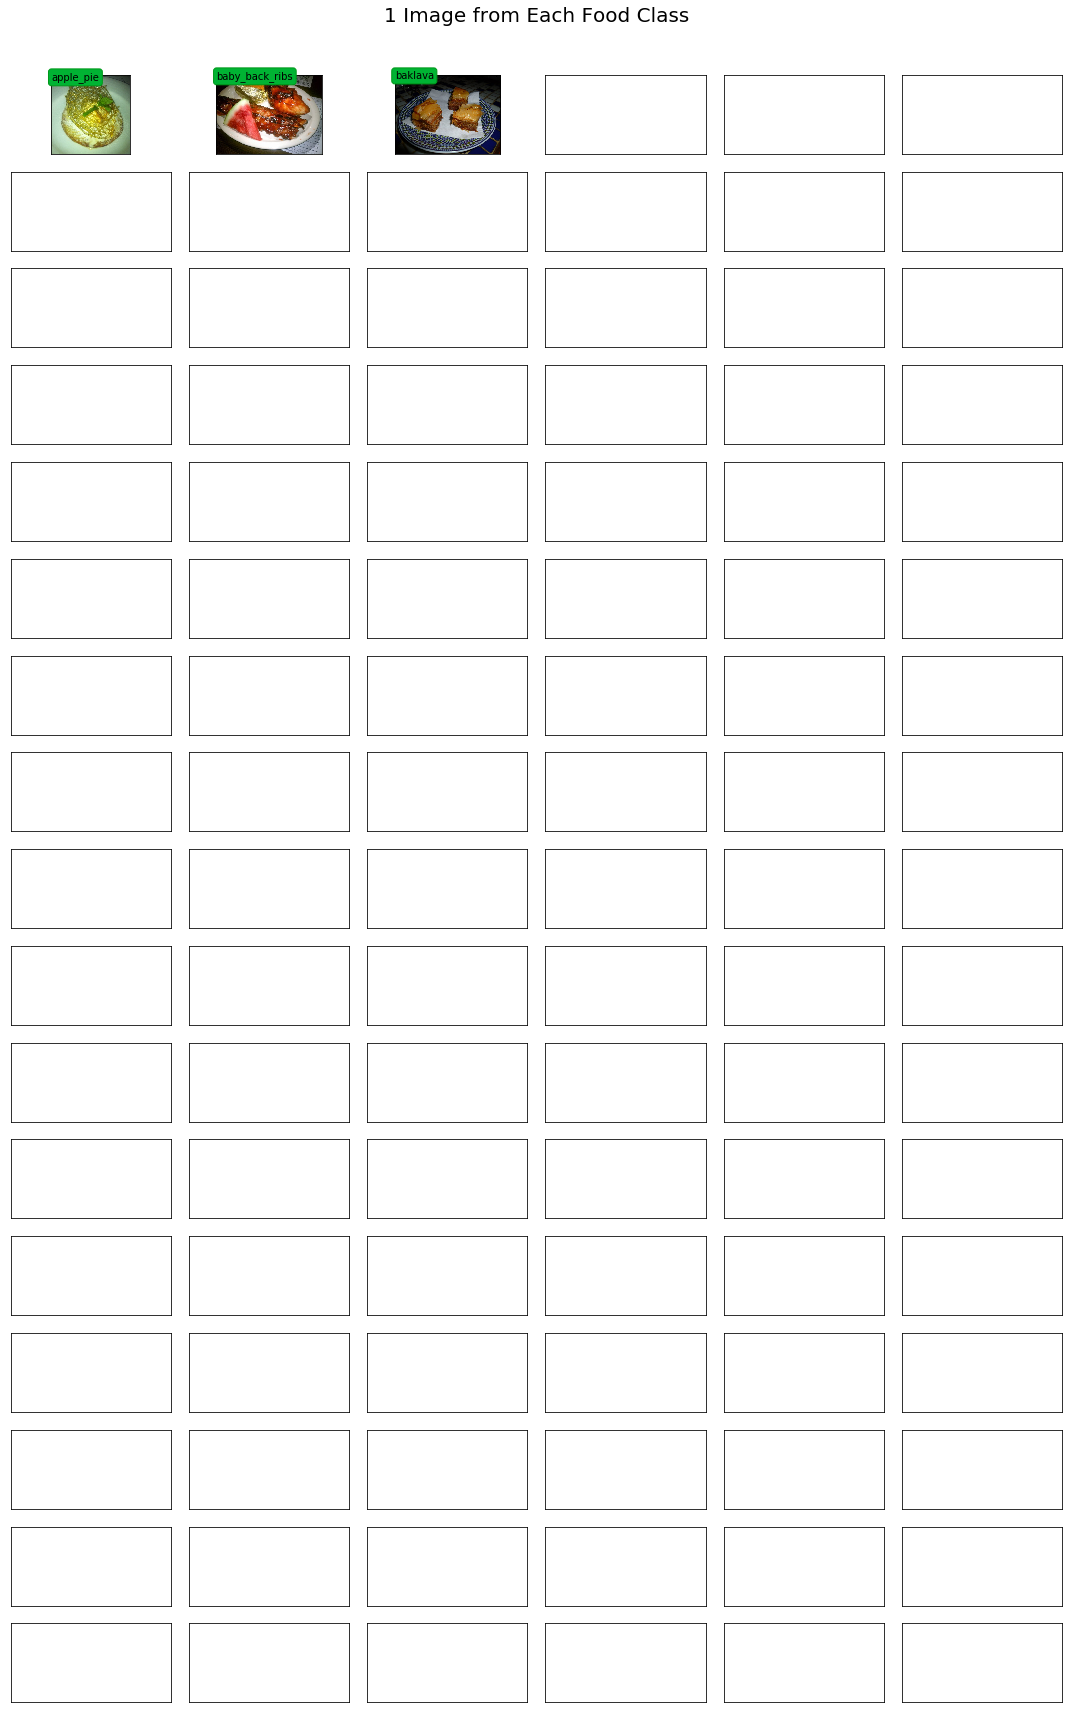

In [19]:
root_dir = 'food-101/images/'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('1 Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


In [8]:
# Setup multiprocessing pool
# Do this early, as once images are loaded into memory there will be ErrorNo 12
# http://stackoverflow.com/questions/14749897/python-multiprocessing-memory-usage

In [20]:
import multiprocessing as mp
num_processes = 6
pool = mp.Pool(processes=num_processes)

Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap

# Label2Idx, IdxLabel
Labels to index and vice versa, for proper label encoding and pretty printing

In [23]:
Label2Idx = {}
Idx2Label = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    Label2Idx = dict(zip(classes, range(len(classes))))
    Idx2Label = dict(zip(range(len(classes)), classes))
    Label2Idx = {v: k for k, v in Idx2Label.items()} #inverted dictionary
sorted_Idx2Label = collections.OrderedDict(sorted(Label2Idx.items()))

# Train/Test Split
The Food-101 dataset has a provided train/test split 

In [24]:
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'): #if Images are not already split
    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('food-101/meta/train.txt')
    test_dir_files = generate_dir_file_map('food-101/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('food-101/images', 'food-101/test', ignore=ignore_train)
    copytree('food-101/images', 'food-101/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

Train/Test files already copied into separate folders.


Loading Images into Memory

In [25]:
# Load dataset images and resize to meet minimum width and height pixel size
from PIL import Image as img
from numpy import *


def load_images(root, min_side=299):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        class_ix = Label2Idx[subdir]
        print(i, class_ix, subdir) 
        for img_name in imgs:
            img_arr = img.open(join(root, subdir, img_name))
            img_arr = np.array(img_arr)
            print (join(root, subdir, img_name))
            img_arr_rs = img_arr
            try:
                w, h, _ = img_arr.shape
                if w < min_side:
                    wpercent = (min_side/float(w))
                    hsize = int((float(h)*float(wpercent)))
                    #print('new dims:', min_side, hsize)
                    img_arr_rs = imresize(img_arr, (min_side, hsize))
                    resize_count += 1
                elif h < min_side:
                    hpercent = (min_side/float(h))
                    wsize = int((float(w)*float(hpercent)))
                    #print('new dims:', wsize, min_side)
                    img_arr_rs = imresize(img_arr, (wsize, min_side))
                    resize_count += 1
                all_imgs.append(img_arr_rs)
                all_classes.append(class_ix)
            except:
                print('Skipping bad image: ', subdir, img_name)
                invalid_count += 1
    print(len(all_imgs), 'images loaded')
    print(resize_count, 'images resized')
    print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)    
X_test, y_test = load_images('food-101/test', min_side=299)

0 1 baby_back_ribs
food-101/test/baby_back_ribs/2886780.jpg
food-101/test/baby_back_ribs/1339637.jpg
food-101/test/baby_back_ribs/2591611.jpg
food-101/test/baby_back_ribs/2079924.jpg
food-101/test/baby_back_ribs/2203767.jpg
food-101/test/baby_back_ribs/1763693.jpg
food-101/test/baby_back_ribs/2245405.jpg
food-101/test/baby_back_ribs/1352978.jpg
food-101/test/baby_back_ribs/3890499.jpg
food-101/test/baby_back_ribs/994232.jpg
food-101/test/baby_back_ribs/2261491.jpg
food-101/test/baby_back_ribs/3412219.jpg
food-101/test/baby_back_ribs/2370716.jpg
food-101/test/baby_back_ribs/18596.jpg
food-101/test/baby_back_ribs/1636617.jpg
food-101/test/baby_back_ribs/112142.jpg
food-101/test/baby_back_ribs/2517831.jpg
food-101/test/baby_back_ribs/1394367.jpg
food-101/test/baby_back_ribs/2816200.jpg
food-101/test/baby_back_ribs/1873449.jpg
food-101/test/baby_back_ribs/1995647.jpg
food-101/test/baby_back_ribs/2130114.jpg
food-101/test/baby_back_ribs/1022479.jpg
food-101/test/baby_back_ribs/776819.jpg
fo

/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


food-101/test/baby_back_ribs/760126.jpg
food-101/test/baby_back_ribs/87031.jpg
food-101/test/baby_back_ribs/649840.jpg
food-101/test/baby_back_ribs/2464308.jpg
food-101/test/baby_back_ribs/2604946.jpg
food-101/test/baby_back_ribs/2232942.jpg
food-101/test/baby_back_ribs/2275499.jpg
food-101/test/baby_back_ribs/2025526.jpg
food-101/test/baby_back_ribs/1698180.jpg
food-101/test/baby_back_ribs/2349904.jpg
food-101/test/baby_back_ribs/3748156.jpg
food-101/test/baby_back_ribs/2053235.jpg
food-101/test/baby_back_ribs/3660437.jpg
food-101/test/baby_back_ribs/3700896.jpg
food-101/test/baby_back_ribs/593493.jpg
food-101/test/baby_back_ribs/1221409.jpg
food-101/test/baby_back_ribs/2145496.jpg
food-101/test/baby_back_ribs/1641429.jpg
food-101/test/baby_back_ribs/3052734.jpg
food-101/test/baby_back_ribs/1329841.jpg
food-101/test/baby_back_ribs/707137.jpg
food-101/test/baby_back_ribs/2066952.jpg
food-101/test/baby_back_ribs/1145041.jpg
food-101/test/baby_back_ribs/1495381.jpg
food-101/test/baby_bac

food-101/test/baklava/2162852.jpg
food-101/test/baklava/2028827.jpg
food-101/test/baklava/3628916.jpg
food-101/test/baklava/1264253.jpg
food-101/test/baklava/1849718.jpg
food-101/test/baklava/3696940.jpg
food-101/test/baklava/332407.jpg
food-101/test/baklava/1138123.jpg
food-101/test/baklava/1448425.jpg
food-101/test/baklava/1746317.jpg
food-101/test/baklava/3645013.jpg
food-101/test/baklava/2718099.jpg
food-101/test/baklava/3136582.jpg
food-101/test/baklava/3885250.jpg
food-101/test/baklava/899196.jpg
food-101/test/baklava/2946891.jpg
food-101/test/baklava/3311502.jpg
food-101/test/baklava/1196728.jpg
food-101/test/baklava/3578527.jpg
food-101/test/baklava/1823708.jpg
food-101/test/baklava/1762550.jpg
food-101/test/baklava/1988719.jpg
food-101/test/baklava/840044.jpg
food-101/test/baklava/2041299.jpg
food-101/test/baklava/3213763.jpg
food-101/test/baklava/2374859.jpg
food-101/test/baklava/640052.jpg
food-101/test/baklava/72326.jpg
food-101/test/baklava/558342.jpg
food-101/test/baklava

/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:32: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


food-101/test/baklava/2379083.jpg
food-101/test/baklava/2021629.jpg
food-101/test/baklava/206902.jpg
food-101/test/baklava/788.jpg
food-101/test/baklava/2556193.jpg
food-101/test/baklava/694258.jpg
food-101/test/baklava/800666.jpg
food-101/test/baklava/2117032.jpg
food-101/test/baklava/3482045.jpg
food-101/test/baklava/2106469.jpg
food-101/test/baklava/721053.jpg
food-101/test/baklava/3340929.jpg
food-101/test/baklava/3655808.jpg
food-101/test/baklava/3117752.jpg
food-101/test/baklava/2073284.jpg
food-101/test/baklava/613574.jpg
food-101/test/baklava/3297567.jpg
food-101/test/baklava/1502186.jpg
food-101/test/baklava/3765756.jpg
food-101/test/baklava/3480784.jpg
food-101/test/baklava/2148215.jpg
food-101/test/baklava/3358883.jpg
food-101/test/baklava/2768985.jpg
food-101/test/baklava/3496527.jpg
food-101/test/baklava/143372.jpg
food-101/test/baklava/343124.jpg
food-101/test/baklava/1062541.jpg
food-101/test/baklava/1915978.jpg
food-101/test/baklava/3570121.jpg
food-101/test/baklava/355

food-101/test/apple_pie/343461.jpg
food-101/test/apple_pie/3280206.jpg
food-101/test/apple_pie/2881877.jpg
food-101/test/apple_pie/2673907.jpg
food-101/test/apple_pie/661475.jpg
food-101/test/apple_pie/2407532.jpg
food-101/test/apple_pie/3547012.jpg
food-101/test/apple_pie/3505644.jpg
food-101/test/apple_pie/101251.jpg
food-101/test/apple_pie/3243441.jpg
food-101/test/apple_pie/1514110.jpg
food-101/test/apple_pie/83981.jpg
food-101/test/apple_pie/257377.jpg
food-101/test/apple_pie/2395631.jpg
food-101/test/apple_pie/317970.jpg
food-101/test/apple_pie/2114765.jpg
food-101/test/apple_pie/646264.jpg
food-101/test/apple_pie/1889575.jpg
food-101/test/apple_pie/1398774.jpg
food-101/test/apple_pie/3108987.jpg
food-101/test/apple_pie/3829004.jpg
food-101/test/apple_pie/2523928.jpg
food-101/test/apple_pie/3809728.jpg
food-101/test/apple_pie/2848506.jpg
food-101/test/apple_pie/688983.jpg
food-101/test/apple_pie/416233.jpg
food-101/test/apple_pie/3497884.jpg
food-101/test/apple_pie/3471337.jpg
fo

In [26]:
X_train, y_train = load_images('food-101/train', min_side=299)

0 1 baby_back_ribs
food-101/train/baby_back_ribs/2148879.jpg
food-101/train/baby_back_ribs/540444.jpg
food-101/train/baby_back_ribs/835791.jpg
food-101/train/baby_back_ribs/2367209.jpg
food-101/train/baby_back_ribs/1416598.jpg
food-101/train/baby_back_ribs/733887.jpg
food-101/train/baby_back_ribs/2483228.jpg
food-101/train/baby_back_ribs/976663.jpg
food-101/train/baby_back_ribs/2094942.jpg
food-101/train/baby_back_ribs/1676905.jpg
food-101/train/baby_back_ribs/1192660.jpg
food-101/train/baby_back_ribs/722824.jpg
food-101/train/baby_back_ribs/3730021.jpg
food-101/train/baby_back_ribs/1343043.jpg
food-101/train/baby_back_ribs/2223058.jpg
food-101/train/baby_back_ribs/795751.jpg
food-101/train/baby_back_ribs/2018808.jpg
food-101/train/baby_back_ribs/148270.jpg
food-101/train/baby_back_ribs/1362359.jpg
food-101/train/baby_back_ribs/3698768.jpg
food-101/train/baby_back_ribs/2769114.jpg
food-101/train/baby_back_ribs/1757611.jpg
food-101/train/baby_back_ribs/604793.jpg
food-101/train/baby_bac

/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


food-101/train/baby_back_ribs/2140118.jpg
food-101/train/baby_back_ribs/603308.jpg
food-101/train/baby_back_ribs/2741921.jpg
food-101/train/baby_back_ribs/633918.jpg
food-101/train/baby_back_ribs/2389166.jpg
food-101/train/baby_back_ribs/247539.jpg
food-101/train/baby_back_ribs/928861.jpg
food-101/train/baby_back_ribs/1718129.jpg
food-101/train/baby_back_ribs/3598573.jpg
food-101/train/baby_back_ribs/1395170.jpg
food-101/train/baby_back_ribs/1941026.jpg
food-101/train/baby_back_ribs/3443942.jpg
food-101/train/baby_back_ribs/620996.jpg
food-101/train/baby_back_ribs/2670701.jpg
food-101/train/baby_back_ribs/538558.jpg
food-101/train/baby_back_ribs/1862790.jpg
food-101/train/baby_back_ribs/1959961.jpg
food-101/train/baby_back_ribs/65686.jpg
food-101/train/baby_back_ribs/3752732.jpg
food-101/train/baby_back_ribs/2561928.jpg
food-101/train/baby_back_ribs/2473664.jpg
food-101/train/baby_back_ribs/5712.jpg
food-101/train/baby_back_ribs/857241.jpg
food-101/train/baby_back_ribs/1608850.jpg
food

/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:32: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


food-101/train/baby_back_ribs/2704350.jpg
food-101/train/baby_back_ribs/1716566.jpg
food-101/train/baby_back_ribs/1558275.jpg
food-101/train/baby_back_ribs/42451.jpg
food-101/train/baby_back_ribs/2344248.jpg
food-101/train/baby_back_ribs/948393.jpg
food-101/train/baby_back_ribs/622552.jpg
food-101/train/baby_back_ribs/1429122.jpg
food-101/train/baby_back_ribs/2984148.jpg
food-101/train/baby_back_ribs/1224799.jpg
food-101/train/baby_back_ribs/701934.jpg
food-101/train/baby_back_ribs/2445231.jpg
food-101/train/baby_back_ribs/65208.jpg
food-101/train/baby_back_ribs/3612206.jpg
food-101/train/baby_back_ribs/2452437.jpg
food-101/train/baby_back_ribs/3010421.jpg
food-101/train/baby_back_ribs/2121992.jpg
food-101/train/baby_back_ribs/677746.jpg
food-101/train/baby_back_ribs/2369576.jpg
food-101/train/baby_back_ribs/2608149.jpg
food-101/train/baby_back_ribs/2223252.jpg
food-101/train/baby_back_ribs/2491343.jpg
food-101/train/baby_back_ribs/1986342.jpg
food-101/train/baby_back_ribs/2076140.jpg


food-101/train/baby_back_ribs/2423451.jpg
food-101/train/baby_back_ribs/2179524.jpg
food-101/train/baby_back_ribs/1007102.jpg
food-101/train/baby_back_ribs/1775388.jpg
food-101/train/baby_back_ribs/3294213.jpg
food-101/train/baby_back_ribs/16366.jpg
food-101/train/baby_back_ribs/3073784.jpg
food-101/train/baby_back_ribs/1291979.jpg
food-101/train/baby_back_ribs/1839467.jpg
food-101/train/baby_back_ribs/2732278.jpg
food-101/train/baby_back_ribs/1520322.jpg
food-101/train/baby_back_ribs/488000.jpg
food-101/train/baby_back_ribs/2284261.jpg
food-101/train/baby_back_ribs/1676906.jpg
food-101/train/baby_back_ribs/999098.jpg
food-101/train/baby_back_ribs/1552922.jpg
food-101/train/baby_back_ribs/1644147.jpg
food-101/train/baby_back_ribs/2955159.jpg
food-101/train/baby_back_ribs/2275367.jpg
food-101/train/baby_back_ribs/1558128.jpg
food-101/train/baby_back_ribs/1267432.jpg
food-101/train/baby_back_ribs/3681407.jpg
food-101/train/baby_back_ribs/679126.jpg
food-101/train/baby_back_ribs/2689115.j

food-101/train/baby_back_ribs/854966.jpg
food-101/train/baby_back_ribs/479382.jpg
food-101/train/baby_back_ribs/1499720.jpg
food-101/train/baby_back_ribs/3583734.jpg
food-101/train/baby_back_ribs/2039521.jpg
food-101/train/baby_back_ribs/1342514.jpg
food-101/train/baby_back_ribs/3202462.jpg
food-101/train/baby_back_ribs/662988.jpg
food-101/train/baby_back_ribs/1576772.jpg
food-101/train/baby_back_ribs/271964.jpg
food-101/train/baby_back_ribs/188943.jpg
food-101/train/baby_back_ribs/853598.jpg
food-101/train/baby_back_ribs/1774172.jpg
food-101/train/baby_back_ribs/1887058.jpg
food-101/train/baby_back_ribs/2505241.jpg
food-101/train/baby_back_ribs/3065515.jpg
food-101/train/baby_back_ribs/2753490.jpg
food-101/train/baby_back_ribs/2546280.jpg
food-101/train/baby_back_ribs/880662.jpg
food-101/train/baby_back_ribs/1346686.jpg
food-101/train/baby_back_ribs/3313124.jpg
food-101/train/baby_back_ribs/2563094.jpg
food-101/train/baby_back_ribs/2674541.jpg
food-101/train/baby_back_ribs/3412115.jpg

food-101/train/baklava/2425106.jpg
food-101/train/baklava/2193566.jpg
food-101/train/baklava/2163946.jpg
food-101/train/baklava/1319301.jpg
food-101/train/baklava/1973849.jpg
food-101/train/baklava/3436596.jpg
food-101/train/baklava/3592425.jpg
food-101/train/baklava/3671071.jpg
food-101/train/baklava/25496.jpg
food-101/train/baklava/998280.jpg
food-101/train/baklava/3466217.jpg
food-101/train/baklava/3429470.jpg
food-101/train/baklava/1121955.jpg
food-101/train/baklava/3145978.jpg
food-101/train/baklava/3841998.jpg
food-101/train/baklava/987735.jpg
food-101/train/baklava/1301231.jpg
food-101/train/baklava/823047.jpg
food-101/train/baklava/3212849.jpg
food-101/train/baklava/2751927.jpg
food-101/train/baklava/2523553.jpg
food-101/train/baklava/2159134.jpg
food-101/train/baklava/1582896.jpg
food-101/train/baklava/2926747.jpg
food-101/train/baklava/3834345.jpg
food-101/train/baklava/1246040.jpg
food-101/train/baklava/1788827.jpg
food-101/train/baklava/1045575.jpg
food-101/train/baklava/14

food-101/train/baklava/1645909.jpg
food-101/train/baklava/825086.jpg
food-101/train/baklava/3766342.jpg
food-101/train/baklava/3893624.jpg
food-101/train/baklava/3533697.jpg
food-101/train/baklava/49917.jpg
food-101/train/baklava/2812401.jpg
food-101/train/baklava/3255376.jpg
food-101/train/baklava/3850924.jpg
food-101/train/baklava/3032522.jpg
food-101/train/baklava/2835603.jpg
food-101/train/baklava/2581982.jpg
food-101/train/baklava/1193297.jpg
food-101/train/baklava/1986808.jpg
food-101/train/baklava/597581.jpg
food-101/train/baklava/1122284.jpg
food-101/train/baklava/322414.jpg
food-101/train/baklava/1692534.jpg
food-101/train/baklava/2939561.jpg
food-101/train/baklava/1458610.jpg
food-101/train/baklava/461212.jpg
food-101/train/baklava/2029991.jpg
food-101/train/baklava/173868.jpg
food-101/train/baklava/1613218.jpg
food-101/train/baklava/139176.jpg
food-101/train/baklava/3168171.jpg
food-101/train/baklava/376052.jpg
food-101/train/baklava/3189724.jpg
food-101/train/baklava/155350

food-101/train/baklava/3778027.jpg
food-101/train/baklava/1327329.jpg
food-101/train/baklava/3547203.jpg
food-101/train/baklava/307354.jpg
food-101/train/baklava/3160989.jpg
food-101/train/baklava/950270.jpg
food-101/train/baklava/2229944.jpg
food-101/train/baklava/3890574.jpg
food-101/train/baklava/2065345.jpg
food-101/train/baklava/723864.jpg
food-101/train/baklava/3747752.jpg
food-101/train/baklava/3793028.jpg
food-101/train/baklava/2426187.jpg
food-101/train/baklava/2428012.jpg
food-101/train/baklava/1109957.jpg
food-101/train/baklava/2467153.jpg
food-101/train/baklava/3691584.jpg
food-101/train/baklava/1165038.jpg
food-101/train/baklava/1487477.jpg
food-101/train/baklava/3676885.jpg
food-101/train/baklava/1458537.jpg
food-101/train/baklava/1851423.jpg
food-101/train/baklava/3015422.jpg
food-101/train/baklava/1133981.jpg
food-101/train/baklava/176061.jpg
food-101/train/baklava/858338.jpg
food-101/train/baklava/1024334.jpg
food-101/train/baklava/1705012.jpg
food-101/train/baklava/23

food-101/train/apple_pie/21063.jpg
food-101/train/apple_pie/2745241.jpg
food-101/train/apple_pie/2586267.jpg
food-101/train/apple_pie/1177254.jpg
food-101/train/apple_pie/1057749.jpg
food-101/train/apple_pie/1323309.jpg
food-101/train/apple_pie/2768268.jpg
food-101/train/apple_pie/2379223.jpg
food-101/train/apple_pie/2601590.jpg
food-101/train/apple_pie/2231842.jpg
food-101/train/apple_pie/3287607.jpg
food-101/train/apple_pie/1667135.jpg
food-101/train/apple_pie/1159801.jpg
food-101/train/apple_pie/3596143.jpg
food-101/train/apple_pie/591398.jpg
food-101/train/apple_pie/2766379.jpg
food-101/train/apple_pie/1361950.jpg
food-101/train/apple_pie/2909830.jpg
food-101/train/apple_pie/2323355.jpg
food-101/train/apple_pie/3031488.jpg
food-101/train/apple_pie/360406.jpg
food-101/train/apple_pie/1528623.jpg
food-101/train/apple_pie/1753171.jpg
food-101/train/apple_pie/1420227.jpg
food-101/train/apple_pie/865073.jpg
food-101/train/apple_pie/3613613.jpg
food-101/train/apple_pie/1447062.jpg
food-1

food-101/train/apple_pie/1484086.jpg
food-101/train/apple_pie/873371.jpg
food-101/train/apple_pie/1816741.jpg
food-101/train/apple_pie/3897758.jpg
food-101/train/apple_pie/2347111.jpg
food-101/train/apple_pie/3783821.jpg
food-101/train/apple_pie/1786261.jpg
food-101/train/apple_pie/2713820.jpg
food-101/train/apple_pie/1200079.jpg
food-101/train/apple_pie/1899134.jpg
food-101/train/apple_pie/2721937.jpg
food-101/train/apple_pie/2527163.jpg
food-101/train/apple_pie/3848012.jpg
food-101/train/apple_pie/769522.jpg
food-101/train/apple_pie/488508.jpg
food-101/train/apple_pie/98449.jpg
food-101/train/apple_pie/1026328.jpg
food-101/train/apple_pie/2627767.jpg
food-101/train/apple_pie/1879193.jpg
food-101/train/apple_pie/2364059.jpg
food-101/train/apple_pie/1191665.jpg
food-101/train/apple_pie/1764457.jpg
food-101/train/apple_pie/934503.jpg
food-101/train/apple_pie/973428.jpg
food-101/train/apple_pie/1830100.jpg
food-101/train/apple_pie/3814557.jpg
food-101/train/apple_pie/794735.jpg
food-101/

food-101/train/apple_pie/2704442.jpg
food-101/train/apple_pie/2769307.jpg
food-101/train/apple_pie/2548878.jpg
food-101/train/apple_pie/2605751.jpg
food-101/train/apple_pie/1818676.jpg
food-101/train/apple_pie/1240585.jpg
food-101/train/apple_pie/2536578.jpg
food-101/train/apple_pie/813881.jpg
food-101/train/apple_pie/2595208.jpg
food-101/train/apple_pie/292333.jpg
food-101/train/apple_pie/939246.jpg
food-101/train/apple_pie/2621542.jpg
food-101/train/apple_pie/3641922.jpg
food-101/train/apple_pie/1558003.jpg
food-101/train/apple_pie/767102.jpg
food-101/train/apple_pie/2777273.jpg
food-101/train/apple_pie/1790730.jpg
food-101/train/apple_pie/3574591.jpg
food-101/train/apple_pie/80734.jpg
food-101/train/apple_pie/2776008.jpg
food-101/train/apple_pie/235537.jpg
food-101/train/apple_pie/1756344.jpg
food-101/train/apple_pie/3059134.jpg
food-101/train/apple_pie/2986199.jpg
food-101/train/apple_pie/605117.jpg
food-101/train/apple_pie/3659123.jpg
food-101/train/apple_pie/2928660.jpg
food-101/

In [27]:
#print('X_train shape', X_train.shape)
#print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_test shape (750,)
y_test shape (750,)


#  Visualisation Tools
Visualising the pictures

class: 2 baklava


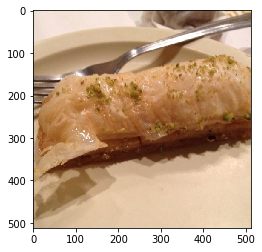

In [28]:
@interact(n=(0, len(X_test)))
def show_pic(n):
    plt.imshow(X_test[n])
    print('class:', y_test[n], Idx2Label[y_test[n]])

0


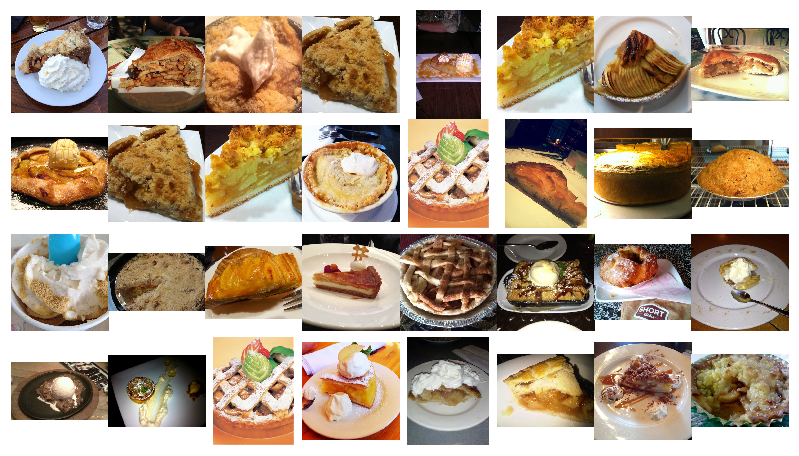

In [29]:
@interact(n_class=sorted_Idx2Label)
def show_random_images_of_class(n_class=0):
    print(n_class)
    nrows = 4
    ncols = 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(12, 8)
    #fig.tight_layout()
    imgs = np.random.choice((y_test == n_class).nonzero()[0], nrows * ncols)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(X_test[imgs[i]])
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    plt.show()

# Data Augmentation
Keras DataGen for Image Augmentation

In [30]:
from keras.utils.np_utils import to_categorical

n_classes =  3 #101 in our case 
#y_train_cat = to_categorical(y_train, nb_classes=n_classes)
y_test_cat = to_categorical(y_test, n_classes)

Check the label_shapes

In [31]:
y_test_cat.shape

(750, 3)

In [32]:
# augmentation configuration we will use for training
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input
#from scipy.misc import imresize #Good Engineers Practice

In [34]:
import keras
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False, # randomly flip images
    zoom_range=[.8, 1],
    channel_shift_range=30,
    fill_mode='reflect')

#train_datagen.set_pipeline([T.random_transform, T.random_crop, T.preprocess_input])
#train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=64, seed=11, pool=pool)

# Batch Generation

In [35]:
#Use flow_from_directory to get all images from Directory see Keras API
directory ='food-101/train'
train_generator = train_datagen.flow_from_directory(directory, 
                      target_size=(299, 299), color_mode='rgb', 
                      classes=None, class_mode='categorical', 
                      batch_size=32, shuffle=True, seed=None, 
                      save_to_dir=None, save_prefix='', 
                      save_format='jpg', follow_links=False, 
                      interpolation='nearest')

Found 2250 images belonging to 3 classes.


In [36]:
#Call the TrainDataGenerator here
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
directory ='food-101/test'
test_generator = test_datagen.flow_from_directory(directory,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

Found 750 images belonging to 3 classes.


Show the augmented Images

In [37]:
def reverse_preprocess_input(x0):
    x = x0 / 2.0
    x += 0.5
    x *= 255.
    return x

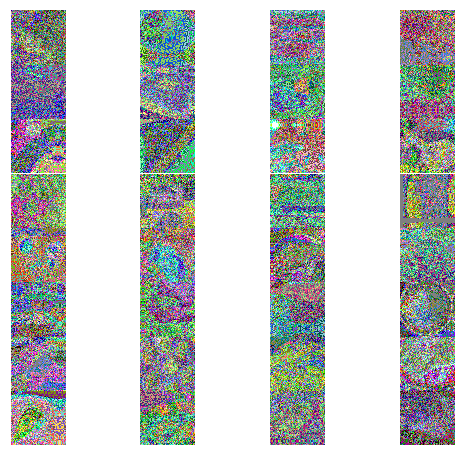

CPU times: user 2.02 s, sys: 284 ms, total: 2.3 s
Wall time: 1.94 s


In [24]:
%%time
@interact()
def show_images(unprocess=True):
    for x in train_generator:
        fig, axes = plt.subplots(nrows=8, ncols=4)
        fig.set_size_inches(8, 8)
        page = 0
        page_size = 32
        start_i = page * page_size
        for i, ax in enumerate(axes.flat):
            img = x[0][i+start_i]
            if unprocess:
                im = ax.imshow(reverse_preprocess_input(img).astype('uint8') )
            else:
                im = ax.imshow(img)
            ax.set_axis_off()
            ax.title.set_visible(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)

        plt.subplots_adjust(left=0, wspace=0, hspace=0)
        plt.show()
        break

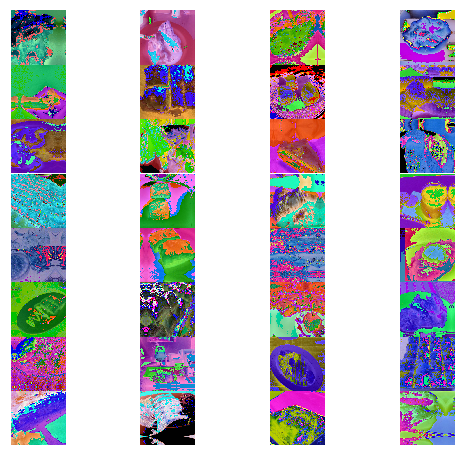

CPU times: user 2.24 s, sys: 292 ms, total: 2.53 s
Wall time: 2.18 s


In [25]:
%%time
show_images(unprocess=False)

# Training

In this case we will be retraining the Inception V3 from Google 

In [38]:
%%time
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import Nadam
from keras.regularizers import l2
import keras.backend as K
import math

K.clear_session()
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
predictions = Dense(n_classes, init='glorot_uniform', W_regularizer=l2(0.0005), activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)
opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004) #Nadam Default optimiser settings
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model4.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model4.log')

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)
model.fit_generator(train_generator,
                    validation_data=test_generator,
                    nb_val_samples=X_test.shape[0],
                    samples_per_epoch=X_train.shape[0],
                    nb_epoch=32,
                    verbose=2,
                    callbacks=[lr_scheduler, csv_logger, checkpointer])

/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_regularizer=<keras.reg..., activation="softmax", kernel_initializer="glorot_uniform")`
/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/home/oushesh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/oushesh/anaconda3/envs/tensorf

Epoch 1/32


KeyboardInterrupt: 

# Save the model here

In [ ]:
model.save('Inception_V3_32_32.hdf5')

In [2]:
from keras.models import load_model

%%time
#model = load_model(filepath='./model4b.10-0.68.hdf5') 
model = load_model(filepath='./Inception_V3_32_32.hdf5') # 86.8039 10-crop Top-1 test accuracy

NameError: name 'load_model' is not defined

# Download Pretrainred Model here

In [3]:
import wget
!wget https://s3.amazonaws.com/stratospark/food-101/model4b.10-0.68.hdf5
#model = load()

--2018-05-17 11:29:47--  https://s3.amazonaws.com/stratospark/food-101/model4b.10-0.68.hdf5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.128.149
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.128.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175117804 (167M) [application/x-www-form-urlencoded]
Saving to: ‘model4b.10-0.68.hdf5’

model4b.10-0.68.hdf 100%[===================>] 167,00M  4,25MB/s    in 42s     

2018-05-17 11:30:30 (3,96 MB/s) - ‘model4b.10-0.68.hdf5’ saved [175117804/175117804]



In [4]:
#Load model here
model.save('model4b.10-0.68.hdf5')

NameError: name 'model' is not defined

# Model Evaluation
Check the Model here

In [ ]:
def predict_10_crop(img, ix, top_n=5, plot=False, preprocess=True, debug=False):
    flipped_X = np.fliplr(img)
    crops = [
        img[:299,:299, :], # Upper Left
        img[:299, img.shape[1]-299:, :], # Upper Right
        img[img.shape[0]-299:, :299, :], # Lower Left
        img[img.shape[0]-299:, img.shape[1]-299:, :], # Lower Right
        center_crop(img, (299, 299)),
        
        flipped_X[:299,:299, :],
        flipped_X[:299, flipped_X.shape[1]-299:, :],
        flipped_X[flipped_X.shape[0]-299:, :299, :],
        flipped_X[flipped_X.shape[0]-299:, flipped_X.shape[1]-299:, :],
        center_crop(flipped_X, (299, 299))
    ]
    if preprocess:
        crops = [preprocess_input(x.astype('float32')) for x in crops]

    if plot:
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))
        ax[0][0].imshow(crops[0])
        ax[0][1].imshow(crops[1])
        ax[0][2].imshow(crops[2])
        ax[0][3].imshow(crops[3])
        ax[0][4].imshow(crops[4])
        ax[1][0].imshow(crops[5])
        ax[1][1].imshow(crops[6])
        ax[1][2].imshow(crops[7])
        ax[1][3].imshow(crops[8])
        ax[1][4].imshow(crops[9])
    
    y_pred = model.predict(np.array(crops))
    preds = np.argmax(y_pred, axis=1)
    top_n_preds= np.argpartition(y_pred, -top_n)[:,-top_n:]
    if debug:
        print('Top-1 Predicted:', preds)
        print('Top-5 Predicted:', top_n_preds)
        print('True Label:', y_test[ix])
    return preds, top_n_preds

    
ix = 13001
predict_10_crop(X_test[ix], ix, top_n=5, plot=True, preprocess=False, debug=True)
